In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import pickle

# **Load Dataset**


In [185]:
df_raw = pd.read_csv('Real_Estate_Sales_2001-2020_GL.csv')
df_raw.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Years until sold
0,2020348,2020,9/13/2021,Ansonia,230 WAKELEE AVE,150500,325000.0,0.4630,Commercial,Nan,1
1,20002,2020,10/2/2020,Ashford,390 TURNPIKE RD,253000,430000.0,0.5883,Residential,Single Family,0
2,200212,2020,3/9/2021,Avon,5 CHESTNUT DRIVE,130400,179900.0,0.7248,Residential,Condo,1
3,200243,2020,4/13/2021,Avon,111 NORTHINGTON DRIVE,619290,890000.0,0.6958,Residential,Single Family,1
4,200377,2020,7/2/2021,Avon,70 FAR HILLS DRIVE,862330,1447500.0,0.5957,Residential,Single Family,1


### Data is from Kaggel.com [Real Estate Sales 2001-2020](https://www.kaggle.com/datasets/derrekdevon/real-estate-sales-2001-2020)

| Attribute | Description|
| -------- | -------- |
|**Serial Number**| Is just a unique set of digits to identify each transaction.|
|**List year**| This is the year that the particular property was put up for sale.|
|**Date Recorded**| Is the date that the transaction was completed. That is, the year the property was bought.|
|**Town**| The town where this property is located.|
|**Address**| The property's address.|
|**Assessed Value**| How much the property is generally considered to be worth.|
|**Sale Amount**| How much the property was actually sold for.|
|**Sales Ratio**| The ratio measures how close the selling price of the property is to it's assessed value.|
|**Property Type**| What kind of property it is.|
|**Residential Type**| If it is a residential property, what type is it.|
|**Years until sold**| Number of years before the property was finally sold.|

In [186]:
df_raw.dropna(inplace=True)

In [187]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997213 entries, 0 to 997212
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Serial Number     997213 non-null  int64  
 1   List Year         997213 non-null  int64  
 2   Date Recorded     997213 non-null  object 
 3   Town              997213 non-null  object 
 4   Address           997213 non-null  object 
 5   Assessed Value    997213 non-null  int64  
 6   Sale Amount       997213 non-null  float64
 7   Sales Ratio       997213 non-null  float64
 8   Property Type     997213 non-null  object 
 9   Residential Type  997213 non-null  object 
 10  Years until sold  997213 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 83.7+ MB


In [188]:
# convert date recorded values into date type data
df_raw['Date Recorded'] = pd.to_datetime(df_raw['Date Recorded'], format='%m/%d/%Y')

In [189]:
# check for duplicates from all columns
df_raw.duplicated().any()

False

In [190]:
# check for duplicates from selected columns
df_raw.duplicated(subset=['List Year','Address','Date Recorded','Years until sold']).any()

True

In [191]:
# it appears that some of the data are inconsistent because a property had multiple transactions within the same date with different assessed value, sale amount, and sale ratio
df_filtered = df_raw.drop_duplicates(subset=['List Year', 'Town', 'Address','Years until sold'])

In [192]:
df_raw.describe()

,Serial Number,List Year,Date Recorded,Assessed Value,Sale Amount,Sales Ratio,Years until sold
count,9.972130e+05,997213.000000,997213,9.972130e+05,9.972130e+05,9.972130e+05,997213.000000
mean,4.311864e+05,2010.189829,2011-06-19 11:36:47.021769216,2.791437e+05,3.911512e+05,1.044637e+01,0.750900
min,0.000000e+00,2001.000000,1999-04-05 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,-18.000000
25%,3.044400e+04,2004.000000,2005-07-25 00:00:00,8.760000e+04,1.400000e+05,4.867000e-01,1.000000
50%,7.030300e+04,2010.000000,2011-01-19 00:00:00,1.383900e+05,2.250000e+05,6.246000e-01,1.000000
75%,1.518780e+05,2016.000000,2017-04-05 00:00:00,2.255600e+05,3.650000e+05,7.852761e-01,1.000000
max,2.000500e+09,2020.000000,2021-09-30 00:00:00,8.815100e+08,5.000000e+09,1.226420e+06,4.000000
std,6.549219e+06,6.237877,NaN,1.670610e+06,5.347270e+06,1.890192e+03,0.434742


In [193]:
(df_raw['Sale Amount']==20).value_counts()

Sale Amount
False    997213
Name: count, dtype: int64

# **Data Cleaning for Numeric Data**  


#### From the description about the data above, we can infer that there is inconsistent value in the 'Years until sold' column. It is not possible to have a negative value.

In [194]:
neg_years_until_sold = df_filtered[df_filtered['Years until sold'] < 0].shape[0]
print(f'Total negative values for "Years until sold" column: {neg_years_until_sold}')

Total negative values for "Years until sold" column: 56


In [195]:
# create new dataframe which consist only positive value for the "Years until sold" column
df1 = df_filtered.copy()
df1 = df1[df1['Years until sold'] >= 0]

# to make sure all values in "Years until sold" column are valid, I'm going to recalculate all the values by substracting list year and the year from date recorded
df1['Years until sold'] = df1['Date Recorded'].dt.year - df1['List Year']

In [196]:
df1.describe()

,Serial Number,List Year,Date Recorded,Assessed Value,Sale Amount,Sales Ratio,Years until sold
count,9.616720e+05,961672.000000,961672,9.616720e+05,9.616720e+05,9.616720e+05,961672.000000
mean,4.384235e+05,2010.269684,2011-07-18 10:58:07.485961472,2.722355e+05,3.951581e+05,8.618162e+00,0.748671
min,8.100000e+01,2001.000000,2001-10-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,3.049000e+04,2004.000000,2005-08-11 00:00:00,8.820000e+04,1.430000e+05,4.866778e-01,0.000000
50%,7.047300e+04,2010.000000,2011-04-05 00:00:00,1.388100e+05,2.276000e+05,6.226598e-01,1.000000
75%,1.600270e+05,2016.000000,2017-05-01 00:00:00,2.256000e+05,3.650425e+05,7.770369e-01,1.000000
max,2.000500e+09,2020.000000,2021-09-30 00:00:00,8.815100e+08,5.000000e+09,1.226420e+06,4.000000
std,6.630489e+06,6.230115,NaN,1.613154e+06,5.437931e+06,1.696565e+03,0.433833


#### Based on the newest description above, there are some anomalies in the minimum and maximum value for assessed value, sale amount, and sales ratio  
  
#### Therefore, I want to find total rows that consist of 0 value in at least 1 out of 3 criteria: assessed value, sale amount, and sales ratio

In [197]:
# display all rows with 0 value with these criteria
zero_assessed_value = df1[df1['Assessed Value']==0].shape[0]
zero_sale_amount = df1[df1['Sale Amount']==0].shape[0]
zero_sales_ratio = df1[df1['Sales Ratio']==0].shape[0]

print(f'''
Total data with 0 value of assessed value: {zero_assessed_value}
Total data with 0 value of sale amount: {zero_sale_amount}
Total data with 0 value of sales ratio: {zero_sales_ratio}
''')


Total data with 0 value of assessed value: 6427
Total data with 0 value of sale amount: 1575
Total data with 0 value of sales ratio: 7771



In [198]:
df1[(df1['Assessed Value'] == 0)
           | (df1['Sale Amount'] == 0)
           | (df1['Sales Ratio'] == 0)].head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Years until sold
75,10323,2001,2002-09-23,Coventry,400 EASTVIEW DR,0,325400.0,0.0,Nan,Nan,1
86,10045,2001,2002-01-03,Bethany,9 SIMPSON CT,96590,0.0,0.0,Nan,Nan,1
96,12532,2001,2002-08-13,Bolton,45 BEACON CT,0,12350.0,0.0,Nan,Nan,1
127,10055,2001,2001-12-04,Stafford,15 JENNIFER LN,0,165155.0,0.0,Nan,Nan,0
133,10502,2001,2002-01-15,Stratford,1101 SUCCESS AVE,0,50000.0,0.0,Nan,Nan,1


#### From the previous insight, we can conclude that all zero values in the Sales Ratio column happened mostly because there is zero value in the Assessed Value or Sale Amount column

#### After scouring the internet, I got some insight regarding the property price and assessment sales ratio:
1. Based on the property price on [landsearch.com](https://www.landsearch.com/), the cheapest property catalog is over $100. 
2. According to [iaao.org](https://www.iaao.org/media/standards/Standard_on_Ratio_Studies.pdf), property assessment sales ratio is between 90% - 110%

#### Therefore, there are several steps I would do:
1. I will filter out all rows that have assessed value and sale amount less than 100 and assign the dataframe into a new variable
2. I will assume that the assessed value and sale amount have either the same number of digits or a maximum difference of 1 digit between them since I got no extra information on the internet to adjust them better.
3. While adjusting the assessed value or the sale amound digit, I will ensure that the Sales Ratio is between 0.2 and 8

#### Assumptions:
1. Assessed Value and Sale Amount have either the same number of digits or a maximum difference of 1 digit.
2. Sales Ratio below 0.2 is considered invalid because it is way too overprice.
3. Sales Ratio above 8 is considered invalid because it is way too underprice.


In [199]:
# filter out all rows that have assign value and sale amount less than 100 and assign the dataframe into a new variable
df1_assessed_and_sale_above100 = df1.copy()
df1_assessed_and_sale_above100 = df1[(df1['Sale Amount'] >= 100) & (df1['Assessed Value'] >= 100)].sort_values(by='Assessed Value', ascending=True)

In [200]:
# Iterate each row to ensure the sales amount digits are equal or equal+1 with the assessed value, and vice versa
for index,row in df1_assessed_and_sale_above100.iterrows():
    assessed_value = row['Assessed Value']
    assessed_value_digits = len(str(assessed_value))

    sale_amount = row['Sale Amount']
    sale_amount_digits = len(str(sale_amount).split('.', 1)[0])

    diff = abs(assessed_value_digits - sale_amount_digits)

    # handling possible conditions
    if (assessed_value_digits > sale_amount_digits) and (diff > 1):
        sale_amount *= 10**diff
        sales_ratio = assessed_value / sale_amount
        if sales_ratio > 8:
            sale_amount *= 10
    elif (assessed_value_digits < sale_amount_digits) and (diff > 1):
        assessed_value *= 10**diff
        sales_ratio = assessed_value / sale_amount
        if sales_ratio < 0.2:
            assessed_value *= 10
    elif (assessed_value_digits == sale_amount_digits):
        sales_ratio = row['Sales Ratio']
        if sales_ratio < 0.2:
            assessed_value *= 10
        elif sales_ratio > 8:
            sale_amount *= 10 

    # Update values in the DataFrame using loc
    df1_assessed_and_sale_above100.at[index, 'Sale Amount'] = sale_amount
    df1_assessed_and_sale_above100.at[index, 'Assessed Value'] = int(assessed_value)
    df1_assessed_and_sale_above100.at[index, 'Sales Ratio'] = round(assessed_value / sale_amount, 5)

In [201]:
df1_assessed_and_sale_above100['Sales Ratio'].std()

1.5580488461079056

#### For the next step, I will handle the rows that have value less than 100 in either the Assessed Value or Sale Amount column, but exceeds 100 in one of them.

In [202]:
# get all rows that have value less than 100 in either the Assessed Value or Sale Amount column, but exceeds 100 in one of them.
df1_assessed_or_sale_below0 = df1.copy()
df1_assessed_or_sale_below0 = df1[((df1['Sale Amount'] < 100) & (df1['Assessed Value'] >= 100))
                               | ((df1['Sale Amount'] >= 100) & (df1['Assessed Value'] < 100)) ]

In [203]:
# margin of error for adjusting the sales ratio
z = 1.96 # confidence level 95%
std = df1_assessed_and_sale_above100['Sales Ratio'].std()
n = df1_assessed_or_sale_below0.shape[0]

# margin of error formula: z * (standard deviation / sqrt(sample size))
moe = z * (std/(n**(1/2)))
moe

0.034834951039981216

In [204]:
# adjust the sales ratio 
for index,row in df1_assessed_or_sale_below0.iterrows():
    # variable initiation
    assessed_value = row['Assessed Value']
    property_type = row['Property Type']
    sales_ratio = round(random.uniform(0.9-moe,1.1+moe),5)
    
    # replace 0 value in the Assessed Value and/or Sale Amount column
    if assessed_value < 100:
        assessed_value = sales_ratio * sale_amount
    elif sale_amount < 100:
        sale_amount = assessed_value / sales_ratio

    df1_assessed_or_sale_below0.loc[index, 'Sale Amount'] = sale_amount
    df1_assessed_or_sale_below0.loc[index, 'Assessed Value'] = int(assessed_value)
    df1_assessed_or_sale_below0.loc[index, 'Sales Ratio'] = sales_ratio

To finish the numeric data cleaning, I will concatenat df1_assessed_or_sale_eq0 and df1_assessed_and_sale_above0

In [205]:
df1_numeric_clean = pd.concat([df1_assessed_and_sale_above100,df1_assessed_or_sale_below0])

In [206]:
df1_numeric_clean.describe()

,Serial Number,List Year,Date Recorded,Assessed Value,Sale Amount,Sales Ratio,Years until sold
count,9.614350e+05,961435.000000,961435,9.614350e+05,9.614350e+05,961435.000000,961435.000000
mean,4.385223e+05,2010.271411,2011-07-19 02:00:47.216921344,3.366544e+06,4.180354e+06,0.810697,0.748659
min,8.100000e+01,2001.000000,2001-10-01 00:00:00,1.000000e+02,1.000000e+02,0.010830,0.000000
25%,3.049000e+04,2004.000000,2005-08-12 00:00:00,9.038000e+04,1.450000e+05,0.494180,0.000000
50%,7.047900e+04,2010.000000,2011-04-06 00:00:00,1.414800e+05,2.300000e+05,0.628690,1.000000
75%,1.600280e+05,2016.000000,2017-05-01 00:00:00,2.321200e+05,3.750000e+05,0.788070,1.000000
max,2.000500e+09,2020.000000,2021-09-30 00:00:00,2.238530e+09,5.000000e+09,99.411200,4.000000
std,6.631303e+06,6.229865,NaN,3.801867e+07,4.201716e+07,1.551919,0.433840



# **Data Cleaning for String Data**

In [207]:
df2 = df1_numeric_clean.copy()

In [208]:
(df2 == 'Nan').value_counts()

Serial Number  List Year  Date Recorded  Town   Address  Assessed Value  Sale Amount  Sales Ratio  Property Type  Residential Type  Years until sold
False          False      False          False  False    False           False        False        False          False             False               594162
                                                                                                   True           True              False               361658
                                                                                                   False          True              False                 5591
                                                True     False           False        False        True           True              False                   20
                                                                                                   False          False             False                    4
Name: count, dtype: int64

In [209]:
df2['Property Type'].value_counts()

Property Type
Single Family     391276
Nan               361678
Condo             103444
Residential        59694
Two Family         25521
Three Family       12129
Vacant Land         2944
Four Family         2102
Commercial          1938
Apartments           479
Industrial           226
Public Utility         4
Name: count, dtype: int64

In [210]:
df2['Residential Type'].value_counts()

Residential Type
Single Family    433885
Nan              367269
Condo            115658
Two Family        28665
Three Family      13596
Four Family        2362
Name: count, dtype: int64

#### Based on the insight about property types and the research I did on study.com, I've decided to devide the property types into 5 groups:
1. Residential (Singe Family, Multi-Family, Condo, Apartment)
2. Industrial
3. Commercial
4. Public Utility
5. Vacant Land

In [211]:
# update the residential type first
df2['Residential Type'] = df2.apply(lambda type: type['Property Type']
                                    if type['Property Type'] in ['Single Family', 'Two Family', 'Three Family', 'Four Family','Condo', 'Apartments']
                                    else type['Residential Type'], axis=1)

df2['Residential Type'].value_counts()

Residential Type
Single Family    433885
Nan              366790
Condo            115658
Two Family        28665
Three Family      13596
Four Family        2362
Apartments          479
Name: count, dtype: int64

In [212]:
# update the property type
df2['Property Type'] = df2['Property Type'].apply(lambda type: 'Residential'
                                                  if type in ['Single Family', 'Two Family', 'Three Family', 'Four Family','Condo', 'Apartments']
                                                  else type)

df2['Property Type'].value_counts()

Property Type
Residential       594645
Nan               361678
Vacant Land         2944
Commercial          1938
Industrial           226
Public Utility         4
Name: count, dtype: int64

#### To determine the property type and the residential type, I'm going to use machine learning to classify the data

In [213]:
df2_ml = df2[['Assessed Value', 'Sale Amount', 'Sales Ratio', 'Years until sold', 'Property Type', 'Residential Type']].copy()
df2_ml['Property Type'].value_counts()

Property Type
Residential       594645
Nan               361678
Vacant Land         2944
Commercial          1938
Industrial           226
Public Utility         4
Name: count, dtype: int64

In [214]:
# filter the dataset from Nan values
df2_ml_not_nan_pt = df2_ml[df2_ml['Property Type'] != 'Nan'].drop('Residential Type', axis=1)
df2_ml_not_nan_pt

,Assessed Value,Sale Amount,Sales Ratio,Years until sold,Property Type
23750,100000,231000.0,0.43290,1,Residential
610046,100000,366000.0,0.27322,1,Residential
453243,100000,435400.0,0.22967,0,Residential
835864,100000,262500.0,0.38095,1,Residential
529368,100000,279000.0,0.35842,1,Residential
...,...,...,...,...,...
992641,510241680,468000000.0,1.09026,1,Residential
994922,444478320,468000000.0,0.94974,1,Residential
996063,458382600,468000000.0,0.97945,1,Residential
996597,427363560,468000000.0,0.91317,1,Residential


#### 1. Prediction for Property Type

In [215]:
def scale_dataset(data, target_column, oversample=False):
    X = data[data.columns[:-1]].values
    y = data[target_column].values

    # scale the feature data to make the value range more reasonable and help the computer learn more efficient
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # oversampling data to make the data distribution more balance
    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)
    
    
    data = np.hstack([X,y.reshape(-1,1)])

    return data,  X, y

In [216]:
# split the dataset
pt_train, pt_test = train_test_split(df2_ml_not_nan_pt, test_size=0.6, random_state= 42, shuffle= True)

In [217]:
# scale and oversample train and test dataset
pt_train, pt_X_train, pt_y_train = scale_dataset(pt_train, 'Property Type', oversample=True)
pt_test, pt_X_test, pt_y_test = scale_dataset(pt_test, 'Property Type', oversample=False)

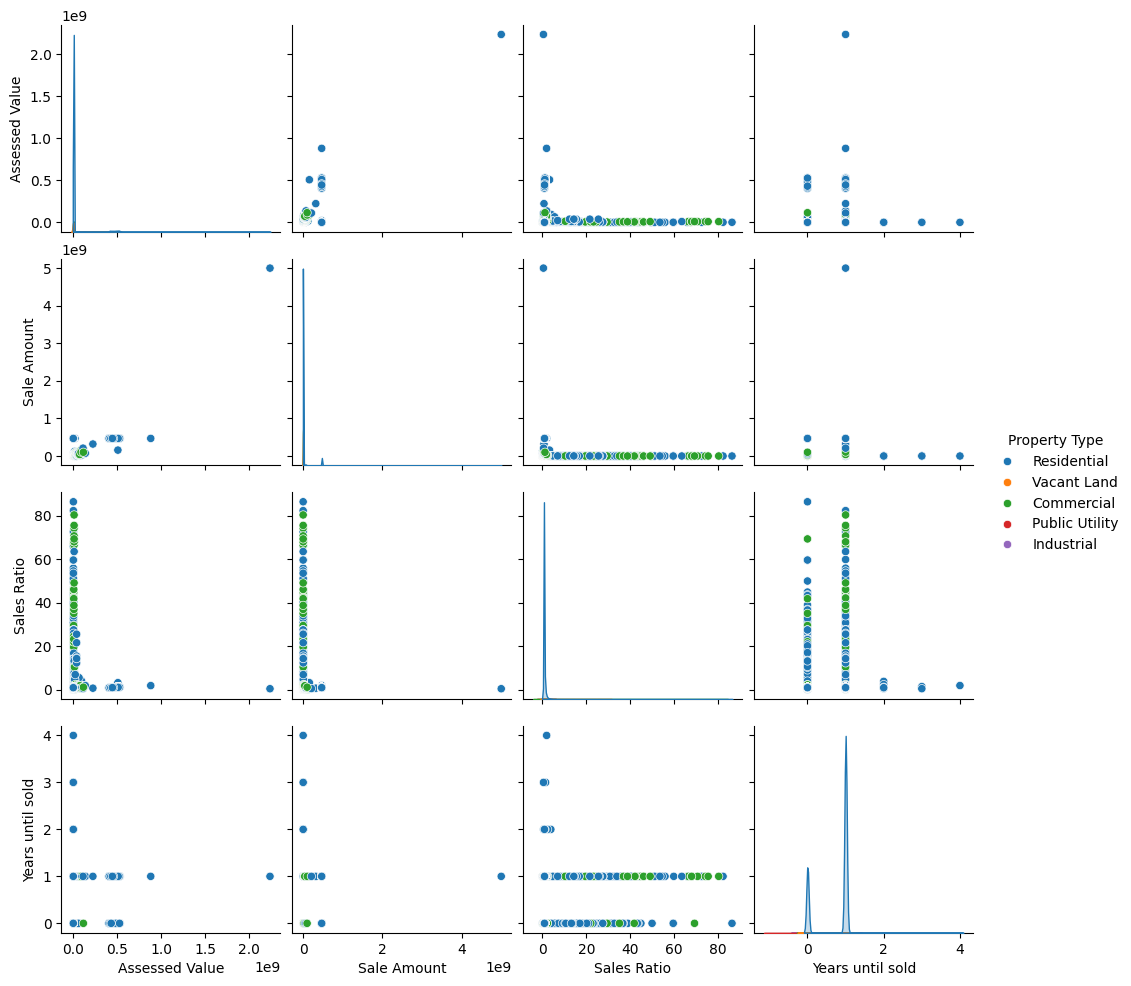

In [218]:
import seaborn as sns 
sns.pairplot(df2_ml_not_nan_pt, hue= 'Property Type')
plt.show()

Since the data points that we have are overlapping one another, the kNN model would perform great in this scenario because the kNN model is based on Euclidean Distance, which the model will predict the class of a point based on its nearby points. It's good for situations where different classes mix in the data.

In [219]:
knn = KNeighborsClassifier()
knn.fit(pt_X_train, pt_y_train) # train knn

# make prediction
pt_y_pred = knn.predict(pt_X_test)

# test set evaluation
report = classification_report(pt_y_test, pt_y_pred)
knn_accuracy_score = accuracy_score(pt_y_test, pt_y_pred)
knn_precision_score = precision_score(pt_y_test, pt_y_pred, average='weighted', zero_division=0)  # Choose the appropriate average
knn_recall_score = recall_score(pt_y_test, pt_y_pred, average='weighted', zero_division=0)  # Choose the appropriate average
knn_f1_score = f1_score(pt_y_test, pt_y_pred, average='weighted', zero_division=0)  # Choose the appropriate average

print('-'*35)
print(f'Accuracy Score: {round(knn_accuracy_score,5)}')
print(f'Precision Score: {round(knn_precision_score,5)}')
print(f'Recall Score: {round(knn_recall_score,5)}')
print(f'F1 Score: {round(knn_f1_score,5)}')
print(f'Labels with no predicted samples: {set(np.unique(pt_y_test)) - set(np.unique(pt_y_pred))}')
print('-'*35)

C:\Users\fredl\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fredl\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fredl\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

-----------------------------------
Accuracy Score: 0.97402
Precision Score: 0.98373
Recall Score: 0.97402
F1 Score: 0.9788
Labels with no predicted samples: {'Public Utility'}
-----------------------------------


kNN hyperparameter tuning for property type prediction model

In [220]:
# define the parameters
knn_params = {
    'n_neighbors': range(1,21,2)
}

# grid search
cv = StratifiedKFold(n_splits= 10)
grid_search = GridSearchCV(estimator=knn, param_grid=knn_params, cv=cv, scoring='accuracy', verbose=2)
grid_result = grid_search.fit(pt_X_train, pt_y_train)

# final model and make prediction
final_knn = KNeighborsClassifier(**grid_result.best_params_)
final_knn.fit(pt_X_train, pt_y_train)
pt_y_pred = final_knn.predict(pt_X_test)

# test set evaluation
knn_accuracy_score = accuracy_score(pt_y_test, pt_y_pred)
knn_precision_score = precision_score(pt_y_test, pt_y_pred, average='weighted', zero_division=0)  # Choose the appropriate average
knn_recall_score = recall_score(pt_y_test, pt_y_pred, average='weighted', zero_division=0)  # Choose the appropriate average
knn_f1_score = f1_score(pt_y_test, pt_y_pred, average='weighted', zero_division=0)  # Choose the appropriate average

print('-'*35)
print(f'Accuracy Score: {round(knn_accuracy_score,5)}')
print(f'Precision Score: {round(knn_precision_score,5)}')
print(f'Recall Score: {round(knn_recall_score,5)}')
print(f'F1 Score: {round(knn_f1_score,5)}')
print(f'Labels with no predicted samples: {set(np.unique(pt_y_test)) - set(np.unique(pt_y_pred))}')
print(f'Best parameters: {grid_result.best_params_}')
print('-'*35)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ......................................n_neighbors=1; total time=   8.5s
[CV] END ......................................n_neighbors=1; total time=   8.5s
[CV] END ......................................n_neighbors=1; total time=   8.6s
[CV] END ......................................n_neighbors=1; total time=   8.4s
[CV] END ......................................n_neighbors=1; total time=   8.3s
[CV] END ......................................n_neighbors=1; total time=   8.3s
[CV] END ......................................n_neighbors=1; total time=   8.4s
[CV] END ......................................n_neighbors=1; total time=   8.1s
[CV] END ......................................n_neighbors=1; total time=   8.3s
[CV] END ......................................n_neighbors=1; total time=   8.5s
[CV] END ......................................n_neighbors=3; total time=   8.8s
[CV] END .....................................

In [221]:
# save knn model
knn_property_type = pickle.dumps(final_knn)

Predict the property type of a feature data that have "Nan" value in the Property Type column

In [222]:
# get all row consisting of "Nan" in the Property Type column
df2_nan_pt_predict = df2_ml[df2_ml['Property Type'] == 'Nan'].drop('Residential Type', axis=1).copy()
df2_nan_pt_predict.head()

,Assessed Value,Sale Amount,Sales Ratio,Years until sold,Property Type
358557,100000,475000.0,0.21053,1,Nan
569452,100000,230000.0,0.43478,1,Nan
387250,1000000,561228.0,1.78181,1,Nan
433070,100,5000.0,0.02000,0,Nan
300041,100000,90000.0,1.11111,1,Nan


In [223]:
# predict the data using the final_knn model
best_knn_property = pickle.loads(knn_property_type)
nan_pt_predict = best_knn_property.predict(df2_nan_pt_predict[df2_nan_pt_predict.columns[:-1]].values)
nan_pt_predict

array(['Residential', 'Residential', 'Residential', ..., 'Residential',
       'Residential', 'Residential'], dtype=object)

In [224]:
# update the all the Nan(s) in the Property Type column with the predicted value
df2_nan_pt_predict['Property Type'] = nan_pt_predict.reshape(-1,)

# combine predicted property type dataframe with the non_nan property type dataframe
df2_pt_predict_done = pd.concat([df2_nan_pt_predict, df2_ml_not_nan_pt])

# update the dataframe that we've prepared to perform machine learning in the beginning so that we can use for the next prediction
df2_ml[df2_ml.columns[:-1]] = df2_pt_predict_done.reindex(df2_ml.index) # use reindex to match indices of df2_ml
df2_ml.head()


,Assessed Value,Sale Amount,Sales Ratio,Years until sold,Property Type,Residential Type
358557,100000,475000.0,0.21053,1,Residential,Nan
569452,100000,230000.0,0.43478,1,Residential,Nan
387250,1000000,561228.0,1.78181,1,Residential,Nan
23750,100000,231000.0,0.43290,1,Residential,Single Family
433070,100,5000.0,0.02000,0,Residential,Nan


In [225]:
df2_ml['Property Type'].value_counts()

Property Type
Residential       956323
Vacant Land         2944
Commercial          1938
Industrial           226
Public Utility         4
Name: count, dtype: int64

#### Now, I'm going to predict the residential type for residential property

In [226]:
df2_ml_rt = df2_ml[df2_ml['Property Type'] == 'Residential'].copy()

In [227]:
df2_ml_rt.head()

,Assessed Value,Sale Amount,Sales Ratio,Years until sold,Property Type,Residential Type
358557,100000,475000.0,0.21053,1,Residential,Nan
569452,100000,230000.0,0.43478,1,Residential,Nan
387250,1000000,561228.0,1.78181,1,Residential,Nan
23750,100000,231000.0,0.43290,1,Residential,Single Family
433070,100,5000.0,0.02000,0,Residential,Nan


In [228]:
df2_ml_rt['Residential Type'].value_counts()

Residential Type
Single Family    433885
Nan              361678
Condo            115658
Two Family        28665
Three Family      13596
Four Family        2362
Apartments          479
Name: count, dtype: int64

In [229]:
df1_numeric_clean.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Years until sold
358557,50138,2005,2006-04-03,Old Saybrook,175 FERRY RD 14,100000,475000.0,0.21053,Nan,Nan,1
569452,10616,2010,2011-09-13,Wethersfield,30 CALIBER LN,100000,230000.0,0.43478,Nan,Nan,1
387250,50178,2005,2006-05-16,Old Saybrook,175 FERRY RD 27,1000000,561228.0,1.78181,Nan,Nan,1
23750,20018,2020,2021-01-21,Andover,24 SKINNER HILL RD,100000,231000.0,0.43290,Residential,Single Family,1
433070,60004,2006,2006-10-05,Brooklyn,POMFRET RD,100,5000.0,0.02000,Nan,Nan,0


In [230]:
df2_ml_non_nan_rt = df2_ml_rt[df2_ml_rt['Residential Type'] != 'Nan'].drop(['Years until sold','Property Type'], axis= 1).copy()
df2_ml_non_nan_rt

,Assessed Value,Sale Amount,Sales Ratio,Residential Type
23750,100000,231000.0,0.43290,Single Family
610046,100000,366000.0,0.27322,Condo
453243,100000,435400.0,0.22967,Condo
835864,100000,262500.0,0.38095,Single Family
529368,100000,279000.0,0.35842,Condo
...,...,...,...,...
992641,510241680,468000000.0,1.09026,Condo
994922,444478320,468000000.0,0.94974,Condo
996063,458382600,468000000.0,0.97945,Single Family
996597,427363560,468000000.0,0.91317,Condo


In [231]:
rt_train, rt_test = train_test_split(df2_ml_non_nan_rt, test_size= 0.6, random_state= 42, shuffle= True)

In [232]:
rt_train, rt_X_train, rt_y_train = scale_dataset(rt_train, 'Residential Type', oversample= True)
rt_test, rt_X_test, rt_y_test = scale_dataset(rt_test, 'Residential Type', oversample= False)

In [233]:
knn_residential = KNeighborsClassifier()

knn_residential.fit(rt_X_train, rt_y_train)
rt_y_pred = knn_residential.predict(rt_X_test)

# result
accuracy = accuracy_score(rt_y_test, rt_y_pred)
precision = precision_score(rt_y_test, rt_y_pred, average= 'weighted') 
recall = recall_score(rt_y_test, rt_y_pred, average= 'weighted')
f1 = f1_score(rt_y_test, rt_y_pred, average= 'weighted')


print('-'*35)
print(f'Accuracy = {accuracy}')
print(f'Precision Score = {precision}')
print(f'Recall Score = {recall}')
print(f'F1-score = {f1}')
print('-'*35)

-----------------------------------
Accuracy = 0.5203636903810958
Precision Score = 0.6027094400271429
Recall Score = 0.5203636903810958
F1-score = 0.5551659100545134
-----------------------------------


In [234]:
models = {
    'k-Nearest-Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

for i in range (len(list(models))):
    model = list(models.values())[i]

    model.fit(rt_X_train, rt_y_train)
    rt_y_pred = model.predict(rt_X_test)

    # result
    accuracy = accuracy_score(rt_y_test, rt_y_pred)
    precision = precision_score(rt_y_test, rt_y_pred, average= 'weighted') 
    recall = recall_score(rt_y_test, rt_y_pred, average= 'weighted')
    f1 = f1_score(rt_y_test, rt_y_pred, average= 'weighted')


    print('-'*35)
    print(list(models.keys())[i])
    print('-'*35)
    print(f'Accuracy = {accuracy}')
    print(f'Precision Score = {precision}')
    print(f'Recall Score = {recall}')
    print(f'F1-score = {f1}')
    print('-'*35)
    print()

-----------------------------------
k-Nearest-Neighbors
-----------------------------------
Accuracy = 0.5203636903810958
Precision Score = 0.6027094400271429
Recall Score = 0.5203636903810958
F1-score = 0.5551659100545134
-----------------------------------

-----------------------------------
Naive Bayes
-----------------------------------
Accuracy = 0.023425741408739667
Precision Score = 0.6086492749609328
Recall Score = 0.023425741408739667
F1-score = 0.0019028372906126107
-----------------------------------

-----------------------------------
Decision Tree
-----------------------------------
Accuracy = 0.5642862548243069
Precision Score = 0.6019334597657552
Recall Score = 0.5642862548243069
F1-score = 0.5821907294396814
-----------------------------------

-----------------------------------
Random Forest
-----------------------------------
Accuracy = 0.7237119065436801
Precision Score = 0.6013410958372558
Recall Score = 0.7237119065436801
F1-score = 0.6231673483840228
----------

END

-----

In [235]:
rfc_params = 
    'n_estimators': [10, 100],
    'criterion': ['gini'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [6, 10, 15, 20]
}

# grid search
cv = StratifiedKFold(n_splits= 10)
random_search = RandomizedSearchCV(estimator= RandomForestClassifier(),
                                 param_distributions= rfc_params,
                                 cv= cv,
                                 n_iter= 10,
                                 scoring= 'accuracy',
                                 verbose= 2,
                                 random_state= 42)
random_result = random_search.fit(rt_X_train, rt_y_train)

# final random forest classifier
final_rfc = RandomForestClassifier(**grid_result.best_params_)
final_rfc.fit(rt_X_train, rt_y_train)
rt_y_pred = final_rfc.predict(rt_X_test)

# test set evaluation
knn_accuracy_score = accuracy_score(pt_y_test, pt_y_pred)
knn_precision_score = precision_score(pt_y_test, pt_y_pred, average='weighted', zero_division=0)  # Choose the appropriate average
knn_recall_score = recall_score(pt_y_test, pt_y_pred, average='weighted', zero_division=0)  # Choose the appropriate average
knn_f1_score = f1_score(pt_y_test, pt_y_pred, average='weighted', zero_division=0)  # Choose the appropriate average

print('-'*35)
print(f'Accuracy Score: {round(knn_accuracy_score,5)}')
print(f'Precision Score: {round(knn_precision_score,5)}')
print(f'Recall Score: {round(knn_recall_score,5)}')
print(f'F1 Score: {round(knn_f1_score,5)}')
print(f'Labels with no predicted samples: {set(np.unique(rt_y_test)) - set(np.unique(rt_y_pred))}')
print(f'Best parameters: {random_result.best_params_}')
print('-'*35)

SyntaxError: unmatched '}' (3843655804.py, line 7)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Use LabelEncoder to convert string labels to numerical labels
label_encoder = LabelEncoder()
rt_y_train_encoded = label_encoder.fit_transform(rt_y_train)
rt_y_test_encoded = label_encoder.transform(rt_y_test)

# Create and train the XGBoost classifier
boost = XGBClassifier()
boost.fit(rt_X_train, rt_y_train_encoded)
rt_y_pred_encoded = boost.predict(rt_X_test)

# Decode the predictions back to original labels if needed
rt_y_pred = label_encoder.inverse_transform(rt_y_pred_encoded)

# Calculate metrics
accuracy = accuracy_score(rt_y_test, rt_y_pred)
precision = precision_score(rt_y_test, rt_y_pred, average='weighted')
recall = recall_score(rt_y_test, rt_y_pred, average='weighted')
f1 = f1_score(rt_y_test, rt_y_pred, average='weighted')

print('-'*35)
print(f'Accuracy = {accuracy}')
print(f'Precision Score = {precision}')
print(f'Recall Score = {recall}')
print(f'F1-score = {f1}')
print('-'*35)


-----------------------------------
Accuracy = 0.425509074346577
Precision Score = 0.6534518925314389
Recall Score = 0.425509074346577
F1-score = 0.45056108284396734
-----------------------------------


In [ ]:
# dict for mean of the Assessed Value per Address
# I don't include the property type because the same address should have the same type
mean_assessed_value_per_address = df1_assessed_and_sale_above100[(df1_assessed_and_sale_above100['Property Type']!='Nan')
                                                                 & (df1_assessed_and_sale_above100['Residential Type']!='Nan')].groupby(['Address'])['Assessed Value'].mean().round(0).to_dict()

# dict for mean of the Sale Amount per Address
# I don't include the property type because the same address should have the same type
mean_sale_amount_per_address = df1_assessed_and_sale_above100[(df1_assessed_and_sale_above100['Property Type']!='Nan')
                                                                 & (df1_assessed_and_sale_above100['Residential Type']!='Nan')].groupby(['Address'])['Sale Amount'].mean().round(0).to_dict()

# dict for mean of the Assessed Value column per town and property type
mean_assessed_value_per_town = df1_assessed_and_sale_above100.groupby(['Town','Property Type'])['Assessed Value'].mean().round(0).to_dict()

# dict for mean of the Sale Amount column per town and property type
mean_sale_amount_per_town = df1_assessed_and_sale_above100.groupby(['Town','Property Type'])['Sale Amount'].mean().round(0).to_dict()

In [ ]:
# for index,row in df1_assessed_or_sale_eq0.iterrows():
#     # variable initiation
#     town = row['Town']
#     address = row['Address']
#     assessed_value = row['Assessed Value']
#     sale_amount = row['Sale Amount']
#     property_type = row['Property Type']

#     sales_ratio = round(random.uniform(0.85,1.15),5)
#     # replace 0 value in the Assessed Value and/or Sale Amount column
#     if assessed_value == 0:
#         if address in mean_assessed_value_per_address:
#             assessed_value = mean_assessed_value_per_address[address]
#         else:
#             assessed_value = mean_assessed_value_per_town[(town, property_type)]
#     if sale_amount == 0:
#         if address in mean_sale_amount_per_address:
#             sale_amount = mean_sale_amount_per_address[address]
#         else:
#             sale_amount = mean_sale_amount_per_town[(town, property_type)]

#     # get the digits difference length between the assessed value and the sale amount
#     assessed_value_digits = len(str(assessed_value).split('.', 1)[0])
#     sale_amount_digits = len(str(sale_amount).split('.', 1)[0])
#     diff_digits = abs(assessed_value_digits - sale_amount_digits)

#     # adjust the digits by multiplying with 10**diff_digits
#     if (assessed_value_digits > sale_amount_digits) and (diff_digits > 1): 
#         sale_amount *= 10**diff_digits
#         sales_ratio = assessed_value / sale_amount
        
#         # According to iaao.org, property assessment sales ratio is between 90% - 110%
#         if (sales_ratio < 0.9) & (sales_ratio > 1.1):
#             sale_amount *= 10
#     elif (sale_amount_digits > assessed_value_digits) and (diff_digits > 1):
#         assessed_value *= 10**diff_digits
#         sales_ratio = assessed_value / sale_amount

#         # According to iaao.org, property assessment sales ratio is between 90% - 110%
#         if (sales_ratio < 0.9) & (sales_ratio > 1.1):
#             assessed_value *= 10

#     # update the sales ratio
#     sales_ratio = round(assessed_value / sale_amount, 5)

#     # Update values in the DataFrame using loc
#     df1_assessed_or_sale_eq0.loc[index, 'Sale Amount'] = sale_amount
#     df1_assessed_or_sale_eq0.loc[index, 'Assessed Value'] = assessed_value
#     df1_assessed_or_sale_eq0.loc[index, 'Sales Ratio'] = sales_ratio